# Optimización Bayesiana

La idea central de la optimización bayesiana es aprender de evaluaciones previas para elegir el siguiente punto a probar.

Tiene dos componentes:
- un modelo probabilístico
- una función de adquisición

El algoritmo:
- Inicializa con X puntos (conjunto de hiperparámetros) aleatorios.
- Itera N veces: Explora y explota, evalúa la función objetivo y elige el mejor (o los mejores) parámetro(s) hasta el momento.
- Al final, devuelve la mejor combinación encontrada.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm

from scipy.interpolate import interp1d
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Dataset

default_df = pd.read_csv("./datasets/Default.csv")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

default_df.head(20)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
5,0,1,919.588530,7491.558572
6,0,0,825.513331,24905.226578
7,0,1,808.667504,17600.451344
8,0,0,1161.057854,37468.529288
9,0,0,0.000000,29275.268293


In [3]:
# como siempre vamos separando nuestras variables predictoras de la variable a predecir
X = default_df.loc[:, ["balance", "income", "student"]].values
y = default_df.loc[:, "default"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train) 
X_test = sc_X.transform(X_test)

print("Número de muestras:", X_train.shape[0])
print("Número de features:", X_train.shape[1])

Número de muestras: 7500
Número de features: 3


---
## Búsqueda bayesiana 1-D (K de KNN)

- Función objetivo: buscamos maximizar el *accuracy*.
- Modelo probabilístico: usamos un proceso gaussiano (GP).
- Función de adquisición: elegimos *Expected Improvement* (EI).

#### Función objetivo

Es la queremos maximizar. La función:
- recibe el hiperparámetro K
- crea un modelo KNN(k)
- calcula el score (el valor que queremos maximizar) como el accuracy promedio,usando validación cruzada 5-fold.

In [4]:
def knn_score_k(k):
    k = int(k)
    model = KNeighborsClassifier(n_neighbors=k)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))


#### Modelo probabilístico

Optamos por un [Proceso Gaussiano (GP)](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

In [5]:
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=5.0, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, random_state=42)

#### Función de adquisición

Elegimos *Expected Improvement* (EI).

In [6]:
def expected_improvement(x_candidates, gp, y_best, xi=0.01):

    mu, sigma = gp.predict(x_candidates, return_std=True)
    mu = mu.ravel()
    sigma = sigma.ravel()
    sigma = np.maximum(sigma, 1e-9) # para evitar divisiones por cero

    improvement = mu - y_best - xi
    Z = improvement / sigma

    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma == 0.0] = 0.0
    return ei

#### Parámetros de búsqueda

In [7]:
K_range = np.arange(1, 51)          # dominio discreto
n_init = 5                          # puntos iniciales aleatorios
n_iter = 15                         # iteraciones del algoritmo

#### Puntos iniciales (exploración aleatoria)

- Se seleccionan n-init (5) valores aleatorios para los parámetros.
- Se evalúa la función objetivo (knn_score_k) en esos puntos.
- Estos son los primeros “puntos muestreados”, que sirven para construir un modelo inicial de la función objetivo.

In [8]:
rng = np.random.default_rng(42)
init_K = rng.choice(K_range, size=n_init, replace=False)
X_eval = np.array(init_K).reshape(-1,1).astype(float)
y_eval = np.array([knn_score_k(k) for k in init_K])

print(f'Valores iniciales elegidos para K: {init_K}')

Valores iniciales elegidos para K: [37 22 32  5 50]


#### Loop de optimización bayesiana

En cada iteración la búsqueda bayesiana 1D va ajustando el modelo probabilístico (GP) y eligiendo nuevos puntos según la función de adquisición (EI).

In [9]:
for it in range(n_iter):
    # entrenamos GP con lo observado hasta ahora
    gp.fit(X_eval, y_eval)
    
    # candidato = todos los K no evaluados aún
    # Evaluamos sobre todo el rango para seleccionar el K con mayor EI
    candidates = np.array(K_range).reshape(-1,1).astype(float)
    
    # calculamos EI para cada candidato
    y_best = y_eval.max()
    ei = expected_improvement(candidates, gp, y_best, xi=0.01)
    
    # excluimos candidatos ya evaluados
    evaluated_set = set(X_eval.ravel().astype(int).tolist())
    ei_masked = ei.copy()
    for i, k in enumerate(candidates.ravel().astype(int)):
        if k in evaluated_set:
            ei_masked[i] = -np.inf
    
    # elegimos el K con mayor EI
    next_idx = int(np.argmax(ei_masked))
    K_next = int(candidates[next_idx,0])
    
    # evaluamos la función objetivo en K_next
    y_next = knn_score_k(K_next)
    
    # actualizamos datos
    X_eval = np.vstack([X_eval, [[K_next]]])
    y_eval = np.concatenate([y_eval, [y_next]])
    
    print(f"Iter {it+1:02d}: probando K={K_next} -> accuracy={y_next:.4f} (mejor hasta ahora = {y_eval.max():.4f})")

# Resultado final
best_idx = np.argmax(y_eval)
best_K = int(X_eval[best_idx,0])
best_score = y_eval[best_idx]
print("\nMejor K encontrado (1D):", best_K, "con accuracy:", best_score)

Iter 01: probando K=1 -> accuracy=0.9552 (mejor hasta ahora = 0.9725)
Iter 02: probando K=33 -> accuracy=0.9725 (mejor hasta ahora = 0.9725)
Iter 03: probando K=10 -> accuracy=0.9716 (mejor hasta ahora = 0.9725)
Iter 04: probando K=43 -> accuracy=0.9725 (mejor hasta ahora = 0.9725)
Iter 05: probando K=16 -> accuracy=0.9712 (mejor hasta ahora = 0.9725)
Iter 06: probando K=27 -> accuracy=0.9723 (mejor hasta ahora = 0.9725)
Iter 07: probando K=46 -> accuracy=0.9712 (mejor hasta ahora = 0.9725)
Iter 08: probando K=19 -> accuracy=0.9715 (mejor hasta ahora = 0.9725)
Iter 09: probando K=40 -> accuracy=0.9724 (mejor hasta ahora = 0.9725)
Iter 10: probando K=13 -> accuracy=0.9712 (mejor hasta ahora = 0.9725)
Iter 11: probando K=7 -> accuracy=0.9712 (mejor hasta ahora = 0.9725)
Iter 12: probando K=25 -> accuracy=0.9719 (mejor hasta ahora = 0.9725)
Iter 13: probando K=48 -> accuracy=0.9712 (mejor hasta ahora = 0.9725)
Iter 14: probando K=29 -> accuracy=0.9727 (mejor hasta ahora = 0.9727)
Iter 15:

### Visualización

**Panel superior — Modelo (GP)**

- Curva azul: predicción del accuracy esperado (μ).
- Banda azul clara: incertidumbre del modelo (±1.96σ).
- Puntos rojos: valores realmente evaluados por cross-validation.
- Línea verde: mejor K observado.

**Panel inferior — Función de adquisición (EI)**
- Curva magenta: Expected Improvement (EI).

Picos altos de EI indican lugares prometedores para muestrear. Se busca un equilibrio entre alta predicción y alta incertidumbre.

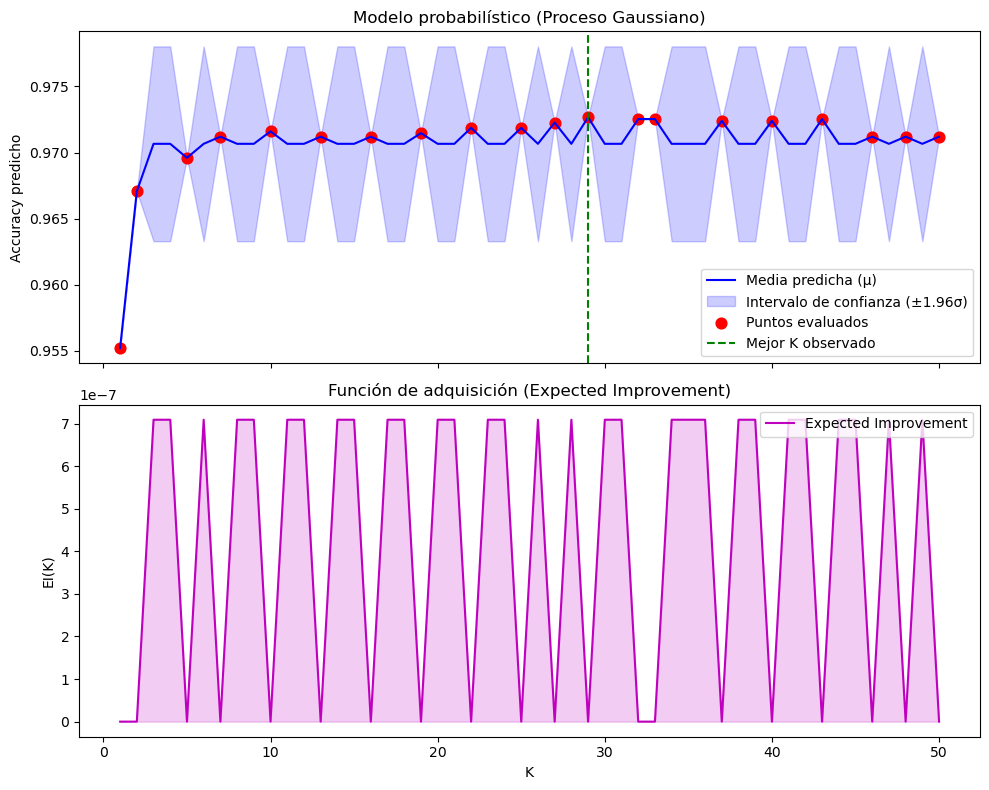

In [10]:
# Entrenamos el modelo final
gp.fit(X_eval, y_eval)
mu, sigma = gp.predict(K_range.reshape(-1,1), return_std=True)
ei = expected_improvement(K_range.reshape(-1,1), gp, y_eval.max(), xi=0.01)

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# 1) Modelo probabilístico (GP)
ax[0].plot(K_range, mu, 'b-', label='Media predicha (μ)')
ax[0].fill_between(K_range, mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2, color='blue', label='Intervalo de confianza (±1.96σ)')
ax[0].scatter(X_eval, y_eval, c='red', s=60, label='Puntos evaluados')
ax[0].axvline(X_eval[np.argmax(y_eval)], color='green', linestyle='--', label='Mejor K observado')
ax[0].set_ylabel("Accuracy predicho")
ax[0].set_title("Modelo probabilístico (Proceso Gaussiano)")
ax[0].legend(loc='lower right')

# 2) Función de adquisición (EI)
ax[1].plot(K_range, ei, 'm-', label='Expected Improvement')
ax[1].fill_between(K_range, 0, ei, color='m', alpha=0.2)
ax[1].set_xlabel("K")
ax[1].set_ylabel("EI(K)")
ax[1].set_title("Función de adquisición (Expected Improvement)")
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


---
## Búsqueda bayesiana para N parámetros

En este ejemplo vamos a buscar 3 parámetros:
- K (vecinos)
- pesos (uniforme o distancia)
- métrica (euclideana o manhattan)

Y definimos:
- Función objetivo: buscamos maximizar el *F1-score*.
- Modelo probabilístico: el mejor valor observado hasta ahora.
- Función de adquisición: seleccionar mejor + exploración ligera.


#### Hiperparámetros a optimizar

In [11]:
k_values = np.arange(1, 51)
weights_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan']

#### Función objetivo
- Recibe los hiperparámetros.
- Crea un modelo KNN con esos parámetros.
- Calcula el score (el valor que queremos maximizar) como el accuracy promedio, usando validación cruzada 5-fold.

In [12]:
def knn_score(params):
    model = KNeighborsClassifier(
        n_neighbors=int(params['K']),
        weights=params['weights'],
        metric=params['metric']
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return np.mean(score)

#### Parámetros de búsqueda

In [13]:
n_init = 5     # puntos iniciales aleatorios
n_iter = 10    # iteraciones del algoritmo

#### Selección inicial de valores random (exploración)

- Se seleccionan n_init (5) valores aleatorios para los parámetros.
- Se evalúa la función objetivo (knn_score) en esos puntos.
- Estos son los primeros “puntos muestreados”, que sirven para construir un modelo inicial de la función objetivo.

In [14]:
# Lista para guardar resultados
evaluated_params = []
evaluated_scores = []

# Puntos iniciales (exploración)
np.random.seed(42)
for _ in range(n_init):  # puntos iniciales
    params = {
        'K': np.random.randint(1, 51),
        'weights': np.random.choice(weights_options),
        'metric': np.random.choice(metric_options)
    }
    score = knn_score(params)
    evaluated_params.append(params)
    evaluated_scores.append(score)

print(f'Valores iniciales elegidos para los hiper-parámetros:')
evaluated_params

Valores iniciales elegidos para los hiper-parámetros:


[{'K': 39, 'weights': 'distance', 'metric': 'euclidean'},
 {'K': 15, 'weights': 'uniform', 'metric': 'manhattan'},
 {'K': 21, 'weights': 'uniform', 'metric': 'manhattan'},
 {'K': 19, 'weights': 'uniform', 'metric': 'euclidean'},
 {'K': 11, 'weights': 'distance', 'metric': 'euclidean'}]

#### Loop de optimización bayesiana

En cada iteración, la búsqueda va ajustando el modelo probabilístico y eligiendo nuevos puntos según la función de adquisición.

- Modelo: Es la lista de evaluaciones previas (evaluated_params y evaluated_scores) y la selección del mejor hasta ahora.
- Función de adquisición: decide dónde muestrear a continuación con una exploración ligera.

In [15]:
for i in range(n_iter):  # iteraciones
    
    # Elegimos el mejor parámetro hasta ahora (explotación)
    best_idx = np.argmax(evaluated_scores)
    best_params = evaluated_params[best_idx].copy()
    
    # Exploración ligera: modificamos un parámetro al azar
    param_to_change = np.random.choice(['K','weights','metric'])
    if param_to_change == 'K':
        best_params['K'] = np.random.randint(1, 51)
    elif param_to_change == 'weights':
        best_params['weights'] = np.random.choice(weights_options)
    else:
        best_params['metric'] = np.random.choice(metric_options)
    
    # Evaluamos nuevo conjunto
    score_new = knn_score(best_params)
    evaluated_params.append(best_params)
    evaluated_scores.append(score_new)
    
    print(f"Iteración {i+1}: {best_params} - F1-score={score_new:.4f}")

Iteración 1: {'K': 11, 'weights': 'distance', 'metric': 'manhattan'} - F1-score=0.3853
Iteración 2: {'K': 2, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3244
Iteración 3: {'K': 11, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3956
Iteración 4: {'K': 11, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3956
Iteración 5: {'K': 33, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3677
Iteración 6: {'K': 11, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3956
Iteración 7: {'K': 44, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3612
Iteración 8: {'K': 49, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3420
Iteración 9: {'K': 11, 'weights': 'distance', 'metric': 'euclidean'} - F1-score=0.3956
Iteración 10: {'K': 11, 'weights': 'distance', 'metric': 'manhattan'} - F1-score=0.3853


#### Resultado final

- Buscamos el mejor score entre todos los puntos evaluados.
- Mostramos el K que maximiza la accuracy según nuestra búsqueda simulada.

In [16]:
best_idx = np.argmax(evaluated_scores)
print("\nMejor combinación encontrada:")
print(evaluated_params[best_idx])
print("con F1-score:", evaluated_scores[best_idx])


Mejor combinación encontrada:
{'K': 11, 'weights': 'distance', 'metric': 'euclidean'}
con F1-score: 0.39560034523048226


### Visualización

Todos los valores utilizados para los hiper-parámetros: K, pesos y métrica de distancia.

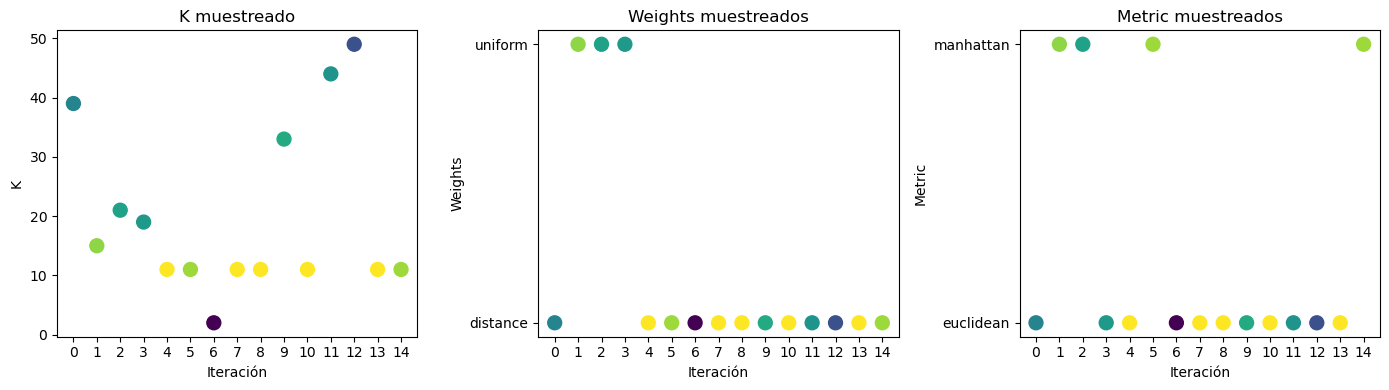

In [17]:
Ks = [p['K'] for p in evaluated_params]
weights = [p['weights'] for p in evaluated_params]
metrics = [p['metric'] for p in evaluated_params]

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.scatter(range(len(Ks)), Ks, c=evaluated_scores, cmap='viridis', s=100)
plt.xticks(range(len(Ks)))
plt.xlabel("Iteración")
plt.ylabel("K")
plt.title("K muestreado")

plt.subplot(1,3,2)
plt.scatter(range(len(weights)), weights, c=evaluated_scores, cmap='viridis', s=100)
plt.xticks(range(len(Ks)))
plt.xlabel("Iteración")
plt.ylabel("Weights")
plt.title("Weights muestreados")

plt.subplot(1,3,3)
plt.scatter(range(len(metrics)), metrics, c=evaluated_scores, cmap='viridis', s=100)
plt.xticks(range(len(Ks)))
plt.xlabel("Iteración")
plt.ylabel("Metric")
plt.title("Metric muestreados")

plt.tight_layout()
plt.show()


### Visualización

Evolución del F1-score. Modelo. Puntos evaluados.

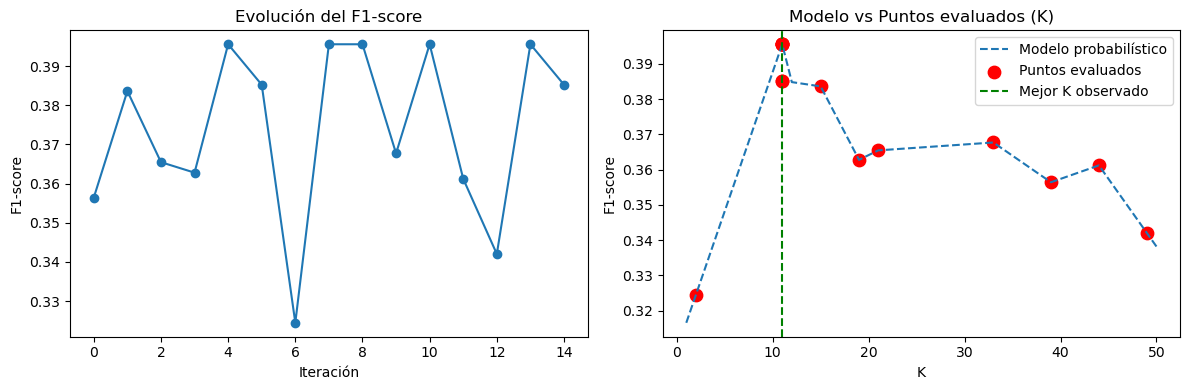

In [18]:
# Extraer valores de cada hiperparámetro
Ks = [p['K'] for p in evaluated_params]
weights = [p['weights'] for p in evaluated_params]
metrics = [p['metric'] for p in evaluated_params]

# Crear el "modelo probabilístico" para K (interpolación lineal)
K_range = np.arange(1, 51)
model = interp1d(Ks, evaluated_scores, kind='linear', fill_value="extrapolate")
pred_scores = model(K_range)

# Crear figura combinada
fig, axs = plt.subplots(1, 2, figsize=(12,4))

# Evolución del accuracy
axs[0].plot(evaluated_scores, marker='o')
axs[0].set_xlabel("Iteración")
axs[0].set_ylabel("F1-score")
axs[0].set_title("Evolución del F1-score")

# Modelo vs puntos evaluados (para K)
axs[1].plot(K_range, pred_scores, '--', label="Modelo probabilístico")
axs[1].scatter(Ks, evaluated_scores, c='red', label="Puntos evaluados", s=80)
axs[1].axvline(evaluated_params[best_idx]['K'], color='green', linestyle='--', label='Mejor K observado')

axs[1].set_xlabel("K")
axs[1].set_ylabel("F1-score")
axs[1].set_title("Modelo vs Puntos evaluados (K)")
axs[1].legend()

plt.tight_layout()
plt.show()


### Entrenamiento y evaluación

In [19]:
# Obtenemos los mejores hiperparámetros encontrados
best_params = evaluated_params[best_idx]

# Creamos el modelo KNN con esos hiperparámetros
best_knn_bayesian = KNeighborsClassifier(
    n_neighbors=int(best_params['K']),
    weights=best_params['weights'],
    metric=best_params['metric']
)

# Entrenamos el modelo con todos los datos de entrenamiento
best_knn_bayesian.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=11, weights='distance')

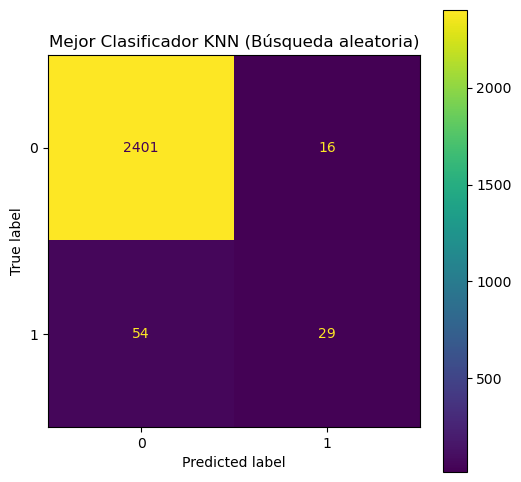

In [20]:
y_pred = best_knn_bayesian.predict(X_test)

cm_best_knn_grid_random = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_grid_random,
                              display_labels=best_knn_bayesian.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Búsqueda aleatoria)");

In [21]:
# Predecimos sobre el conjunto de test
y_pred = best_knn_bayesian.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
# Suponiendo problema binario: cm = [[TN, FP], [FN, TP]]
TN, FP, FN, TP = cm.ravel()  

# Métricas
TPR = TP / (TP + FN)  # Sensibilidad / Recall
TNR = TN / (TN + FP)  # Especificidad
balanced_accuracy = (TPR + TNR) / 2
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Mostrar resultados
print("Mejor Clasificador KNN (Búsqueda Bayesiana)")
print(f"Sensibilidad (Recall): {TPR:.4f}")
print(f"Especificidad: {TNR:.4f}")
print(f"Exactitud balanceada: {balanced_accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recuperación (Recall): {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Mejor Clasificador KNN (Búsqueda Bayesiana)
Sensibilidad (Recall): 0.3494
Especificidad: 0.9934
Exactitud balanceada: 0.6714
Precisión: 0.6444
Recuperación (Recall): 0.3494
F1-score: 0.4531
